STEP 1 : IMPORTING ALL LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

STEP 2 : LOADING THE DATASETS

In [2]:
df = pd.read_excel('Train.xlsx')
df_test = pd.read_csv('Test.csv')

STEP 3 : DATA CLEANING 

In [3]:
df = df.dropna(subset=['HUNDRED_BLOCK', 'HOUR', 'MINUTE'])
df['NEIGHBOURHOOD'] = df['NEIGHBOURHOOD'].fillna('Unknown')

In [4]:
df.head()

,TYPE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude,HOUR,MINUTE,YEAR,MONTH,DAY,Date
0,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,16.0,15.0,1999,5,12,1999-05-12
1,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,15.0,20.0,1999,5,7,1999-05-07
2,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,16.0,40.0,1999,4,23,1999-04-23
3,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,11.0,15.0,1999,4,20,1999-04-20
4,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,17.0,45.0,1999,4,12,1999-04-12


In [5]:
df.columns.tolist()

['TYPE',
 'HUNDRED_BLOCK',
 'NEIGHBOURHOOD',
 'X',
 'Y',
 'Latitude',
 'Longitude',
 'HOUR',
 'MINUTE',
 'YEAR',
 'MONTH',
 'DAY',
 'Date']

In [6]:
df.isnull().sum()

TYPE             0
HUNDRED_BLOCK    0
NEIGHBOURHOOD    0
X                0
Y                0
Latitude         0
Longitude        0
HOUR             0
MINUTE           0
YEAR             0
MONTH            0
DAY              0
Date             0
dtype: int64

In [7]:
df.shape

(425187, 13)

STEP 4 : GEOPANDAS DATAFRAME 

In [8]:
df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

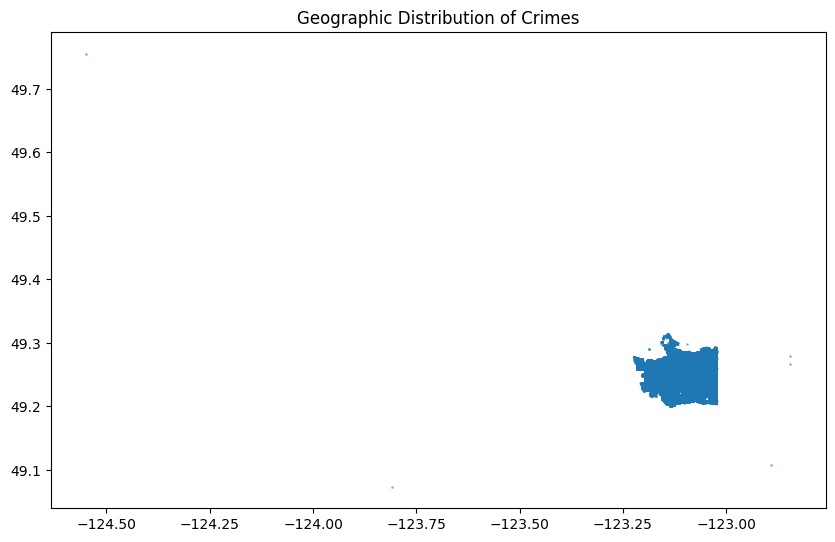

In [9]:
gdf.plot(figsize=(10, 10), alpha=0.4, markersize=1)
plt.title("Geographic Distribution of Crimes")
plt.show()

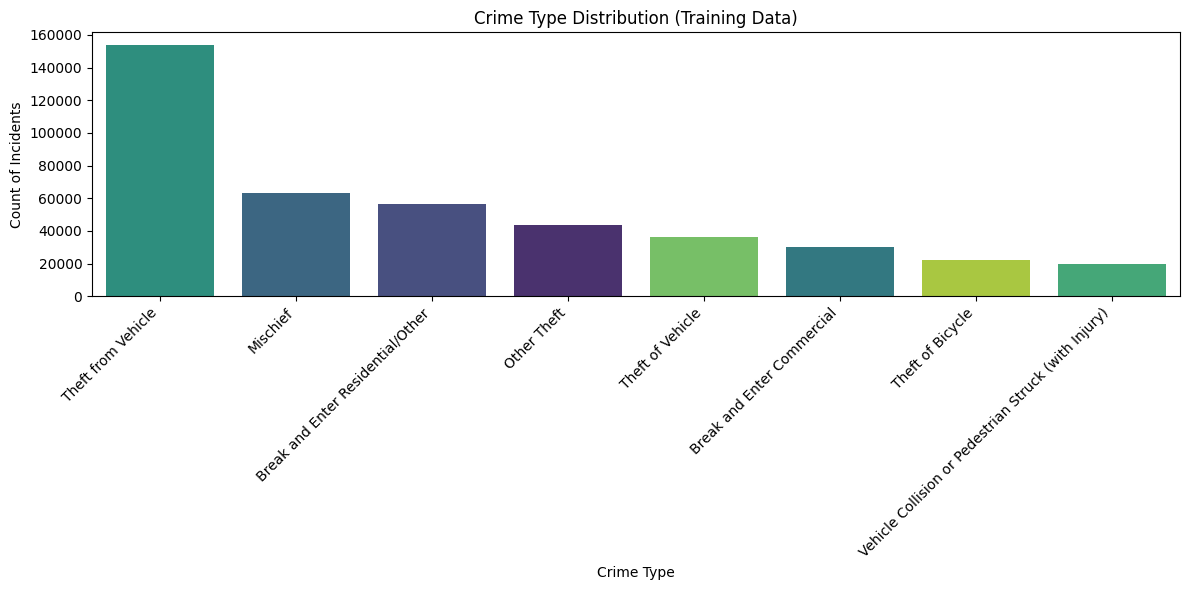

In [31]:
#Chart for each Crime Type

plt.figure(figsize=(12, 6))
sns.countplot(
    data=df,
    x='TYPE',
    hue = 'TYPE',
    dodge = False,
    legend = False,
    order=df['TYPE'].value_counts().index,   # order bars by frequency
    palette='viridis'
)
plt.xticks(rotation=45, ha='right')                  # rotate labels for readability
plt.title('Crime Type Distribution (Training Data)')
plt.xlabel('Crime Type')
plt.ylabel('Count of Incidents')
plt.tight_layout()
plt.savefig("crime_type_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

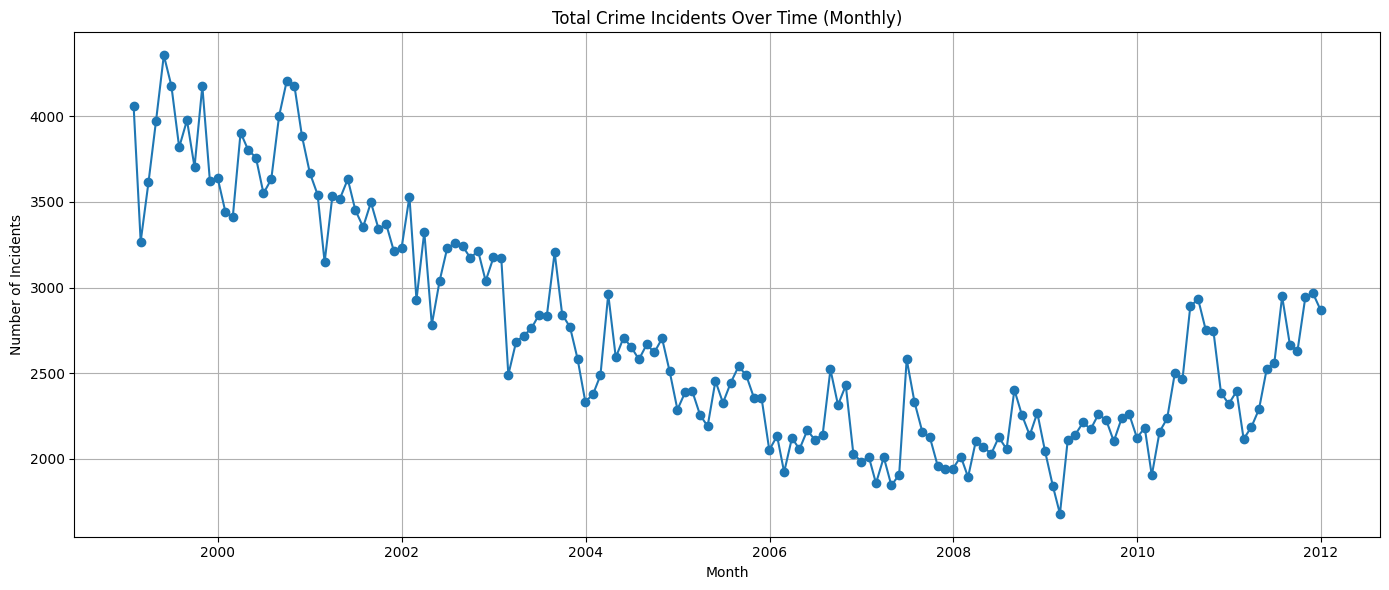

In [12]:
df_time = df.copy()
df_time['Date'] = pd.to_datetime(df_time['Date'])
df_time.set_index('Date', inplace=True)

monthly_counts = (
    df_time
    .resample('ME')                  # group by month
    .size()                         # count incidents
    .rename('Incident_Counts')      # name the resulting series
    .to_frame()                     # convert to DataFrame
)

plt.figure(figsize=(14, 6))
plt.plot(
    monthly_counts.index,
    monthly_counts['Incident_Counts'],
    marker='o',
    linestyle='-',
    linewidth=1.5
)
plt.title('Total Crime Incidents Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.tight_layout()
plt.show()

STEP 5 : TEMPORAL FEATURE ENGINEERING 

In [13]:
df['TimeOfDay'] = df['HOUR'].apply(lambda h: (
    'Night' if h < 6 else 'Morning' if h < 12 else 'Afternoon' if h < 18 else 'Evening'))


In [14]:

# Cyclical encoding of hour and month
df['HOUR_sin'] = np.sin(2 * np.pi * df['HOUR'] / 24)
df['HOUR_cos'] = np.cos(2 * np.pi * df['HOUR'] / 24)
df['MONTH_sin'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['MONTH_cos'] = np.cos(2 * np.pi * df['MONTH'] / 12)

STEP 6 :  Monthly Aggregation for Modeling 


In [15]:
grouped = df.groupby(['YEAR', 'MONTH', 'TYPE']).size().reset_index(name='Incident_Counts')
X = grouped[['YEAR', 'MONTH', 'TYPE']]
y = grouped['Incident_Counts']
X_encoded = pd.get_dummies(X, columns=['TYPE'])

STEP 7 : TRAIN TEST SPLIT

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

STEP 8. XGBoost Model Training 


In [18]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

STEP 9 : MODEL EVALUATION

In [19]:
y_pred = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("XGBoost RMSE:", rmse)
print("XGBoost R^2 Score:", r2)

XGBoost RMSE: 48.50843849297429
XGBoost R^2 Score: 0.9711658954620361


STEP 10 : SHAP EXPLAINABILITY

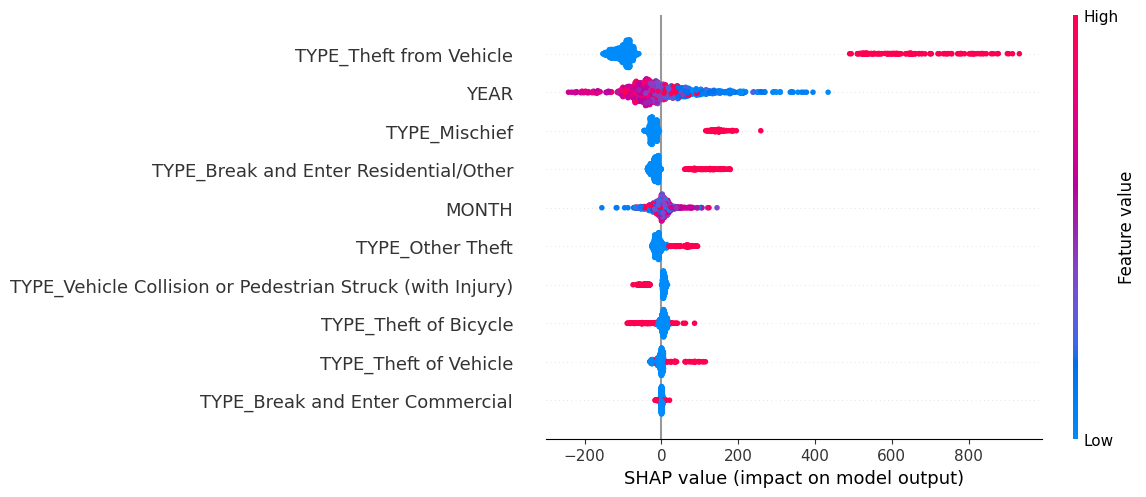

In [21]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)


STEP 11 : PREPARE TEST DATA 

In [22]:
X_test = df_test[['YEAR', 'MONTH', 'TYPE']]
X_test_encoded = pd.get_dummies(X_test, columns=['TYPE'])
X_test_encoded = X_test_encoded.reindex(columns=X_train.columns, fill_value=0)

In [23]:
test_preds = xgb_model.predict(X_test_encoded)
df_test['Incident_Counts'] = test_preds

In [24]:
# Save Output
df_test.to_csv('crime_predictions.csv', index=False)
print("Predictions saved to 'crime_predictions.csv' ")

Predictions saved to 'crime_predictions.csv' 


In [26]:
df_output = pd.read_csv('crime_predictions.csv')

In [27]:
df_output.head()

,YEAR,MONTH,TYPE,Incident_Counts
0,2013,6,Vehicle Collision or Pedestrian Struck (with I...,149.72475
1,2013,6,Theft of Vehicle,104.74830
2,2013,6,Theft of Bicycle,406.01720
3,2013,6,Theft from Vehicle,744.21400
4,2013,6,Other Theft,370.91434


In [28]:
import joblib

In [29]:
joblib.dump(xgb_model, 'crime_model.pkl')


['crime_model.pkl']

In [30]:
joblib.dump(X_train.columns.tolist(), 'model_columns.pkl')


['model_columns.pkl']